# Mount Drive

This section is only if you are working in Google Colab as you will need to mount your Google Drive to the notebook for access to the dataset stored in your Google Drive

In [17]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [18]:
# install keras-vggface library
!pip install keras-vggface

# dependencies for keras-vggface to work
!pip install keras_applications
!pip install keras_preprocessing

# use Multi-Task Cascaded CNN (MTCNN) for face detection
# eg find and extract faces from photos
# state of art deep learnnig model for face detection in 2016
# install the mtcnn package
!pip install mtcnn

# replace from keras.engine.topology import get_source_inputs to from keras.utils.layer_utils import get_source_inputs
# in models.py for keras-vggface to work
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

20952

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D

import os
import numpy as np
import pandas as pd
import seaborn as sns
import random

## Google Colab to change directory to current working directory

This section is only if you are working in Google Colab to change to your current working directory so you can access the dataset.

PLEASE NOTE that the data path specified in this notebook is only valid for working in Google Colab. YOU WILL. NEED TO EDIT THE PATH ACCORDINGLY to where your dataset or your folders are.

In [52]:
cd drive/MyDrive/Colab\ Notebooks/GA-Capstone/

'/content/drive/My Drive/Colab Notebooks/GA-Capstone'

In [21]:
capstone_dir = os.getcwd()

In [22]:
capstone_dir

'/content/drive/My Drive/Colab Notebooks/GA-Capstone'

# Function to prepare model

In [23]:
def prepare_embedding_model(layers_dims, layers_name, num_class, model_weights, dropout_value=None, dropout_name=None):
  #custom parameters

  # nb_class = 100
  # hidden_dim = 512

  # specify input for custom model, model -> resnet50, senet50, vgg16
  vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
  # last_layer = vgg_model.get_layer('avg_pool').output

  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)

  if dropout_name and dropout_value:
    for dims, layer, value, name in zip(layers_dims, layers_name[:-1], dropout_value, dropout_name):
      x = Dense(dims, activation='relu', name=layer)(x)
      x = Dropout(value, name=name)(x)
  else:
    for dims, layer in zip(layers_dims, layers_name[:-1]):
      x = Dense(dims, activation='relu', name=layer)(x)
      # for value, name in zip(dropout_value, dropout_name):
      #   print(name)
        
  
  out = Dense(num_class, activation='softmax', name=layers_name[-1])(x)
  
  # # freeze all pre train model layers
  # for layer in vgg_model.layers:
  #   layer.trainable = False

  # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=vgg_model.input, outputs=out)

  # load pre-trained model weights
  custom_vgg_model.load_weights(model_weights)

  # remove last layer
  custom_vgg_model = Model(inputs=custom_vgg_model.input, outputs=custom_vgg_model.get_layer('pool5').output)
  custom_vgg_model_last_layer = custom_vgg_model.output

  # attach global avg pooling to last layer
  custom_vgg_model_out = GlobalAveragePooling2D(name='avg_pooling')(custom_vgg_model_last_layer)

  # # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=custom_vgg_model.input, outputs=custom_vgg_model_out)

  # compile model
  custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return custom_vgg_model

# Similarity Testing

In this section, 2 random samples of 1000 pair of images were used to test for the similarity probability. For the model to perform, we expect a paired-image of different person to have a low similarity probability while another paired-image of the same person to have a high similarity probability.

## Functions for embeddings, compute cosine similarity

In [24]:
# # face verification with the VGGFace2 model
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
  # load image from file
  pixels = plt.imread(filename)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
    
  ## try to catch if image do not detect any face
  try:
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # face_array = asarray(image)
    face_array = np.array(image)
    return face_array


  except IndexError:
    pass

 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames, model):
	# extract faces
  faces = [extract_face(f) for f in filenames]

  # print(type(faces[0]), type(faces[1]))

  try:

    # samples = asarray(faces, 'float32') # ValueError: setting an array element with a sequence.
    samples = np.array(faces, 'float32') # ValueError: setting an array element with a sequence.

    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)

    # perform prediction
    yhat = model.predict(samples)
    # print(f'prediction length is {len(yhat)}')
    return yhat
  except:
    return None

# determine if a candidate face is a match for a known face
def similar_prob(known_embedding, candidate_embedding, person_name, img1, img2, person_name2=None, similar=True):
	# calculate distance between embeddings
  # 1 - cosine similiatiry -> cosine similarity = 1 - cosine distance
  score = cosine(known_embedding, candidate_embedding)
  cosine_similarity = round((1 - score)*100, 2)
  # print('similar funct')
  if similar:
    # print('similar')
    # print(f'Face in {img1} is (%.2f) similiar to {img2} for {player_name.replace('_', ' ')}' % ((1 - score)*100))
    print(f"Face in {img1} is {cosine_similarity}% similar to {img2} for {person_name.replace('_', ' ')}")

  else:
    # print('diff')
    # print(f'Face in {img1} is (%.2f) similiar to {img2} for {player_name.replace('_', ' ')}' % ((1 - score)*100))
    print(f"Face in {img1} for {person_name.replace('_', ' ')} is {cosine_similarity}% similar to face in {img2} for {person_name2.replace('_', ' ')}")   
  
  return cosine_similarity

## Function to get the probability of 2 images

In [25]:
%%time
# takes about 1hr for 1000 comparison
def get_probability(num_test, model, img_list_same=None, img_list_diff=None, similar=True):

  score = []
  img_cmp = []
  name = []
  to_continue = True
  
  # check probability for same person but different img
  if similar:
    # print('similar')
    if img_list_same is None:
      raise Exception("Please input img_list_same")    
    img_list = img_list_same

  # check probability for different person
  else:
    # print('diff')
    if img_list_diff is None:
      raise Exception("Please input img_list_same")    
    img_list = img_list_diff
    # print(img_list[0])
    
  
  # while to_continue:

  for img in img_list:
    
      img1_path = img[0]
      img2_path = img[1]

      embeddings = get_embeddings([img1_path, img2_path], model)

      try:
          
        if len(embeddings) == 2:
            
          # split path to get the img name and folder name
          img1 = os.path.split(img1_path)[1]
          img2 = os.path.split(img2_path)[1]
          name_folder = os.path.split(os.path.split(img1_path)[0])[1]

          if similar: 

            similarity = similar_prob(embeddings[0], embeddings[1], name_folder, img1, img2)
            name.append(name_folder.replace('_', ' '))
          else:
            # split path to get 2nd foler name
            name_folder2 = os.path.split(os.path.split(img2_path)[0])[1]
 
            similarity = similar_prob(embeddings[0], embeddings[1], name_folder, img1, img2, person_name2=name_folder2, similar=False)
            name.append([name_folder.replace('_', ' '), name_folder2.replace('_', ' ')])

          score.append(similarity)
          img_cmp.append([img1, img2])

        # check how many comparison have been done
        print(f'{len(score)} comparison, {num_test-len(score)} to go')
      except:
        pass
        
      # check if number of test done
      if len(score) == num_test:
        break
    # to_continue = False

  return score, img_cmp, name

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


## Function to plot histogram

In [26]:
def plot_hist_one(df, title):
  ax = sns.displot(
      df['Probability'], 
      kde=True
  )

  # Adjust title and axis labels directly
  plt.title(
      title, 
      fontsize = 16,
      fontweight = 'bold'
  ) # title with fontsize 20
  plt.xlabel(
      'Probability', 
      fontsize = 14,
      fontweight='bold'
  ) # x-axis label with fontsize 15
  plt.ylabel(
      'Frequency', 
      fontsize = 14,
      fontweight='bold'
  ); # y-axis label with fontsize 15

In [50]:
def plot_hist(df_list, title_list, main_title, num_plots, figsize):

  # rows = round(len(x_cols)/3)
  fig, ax = plt.subplots(1, num_plots, figsize=figsize)
  ax = ax.ravel()
    
  for idx, feature in enumerate(df_list):
      # if change_h:
      hist = sns.histplot(

                    df_list[idx]['Probability'], 
                    kde=True,
                    #data=df,
                    ax=ax[idx]        
        )
      hist.set_ylabel('Frequency', fontdict={'fontsize':16, 'fontweight': 'bold'})
      hist.set_xlabel('Probability (%)', fontdict={'fontsize':16, 'fontweight': 'bold'})
      hist.axvline(54.4, color='red')

            
      hist.set_title(f'Histogram for {title_list[idx]}', fontdict={'fontsize':20, 'fontweight': 'bold'})

    
  # if (len(df_list) % 4) != 0:
  #     # remove extra subplot that are not used
  #     ax.flat[-1].set_visible(False)
    
  plt.suptitle(main_title + '\n', fontsize=24, fontweight='bold', y=0.95);
  plt.show()


## Set datapath

In [28]:
dataset_path = 'dataset/train-valid-test/test'

## Randomly get 2000 samples for testing

In [29]:
def get_samples(dataset_path, dataset_path2, samples_size, similar=True):

  samples = []
  for _ in range(samples_size):
    if similar:
      # print('similar get prob')
      name_folder = random.choice(os.listdir(dataset_path))
      img1 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      # to check if img1 is the same as img2
      # if same, change img2
      while img1 == img2:
        img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))

      img1_path = os.path.join(dataset_path, name_folder, img1)
      img2_path = os.path.join(dataset_path, name_folder, img2)

    # check probability for different person
    else:
      # print('diff get prob')
      name_folder = random.choice(os.listdir(dataset_path))
      name_folder2 = random.choice(os.listdir(dataset_path2))
      # check if folder1 is not the same as folder2
      # which means different person
      while name_folder == name_folder2:
        name_folder2 = random.choice(os.listdir(dataset_path2))

      img1 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder2)))
        
      img1_path = os.path.join(dataset_path, name_folder, img1)
      img2_path = os.path.join(dataset_path2, name_folder2, img2)

    samples.append([img1_path, img2_path])

  return samples

In [ ]:
%%time
samples_diff = get_samples(dataset_path, dataset_path, 2000, similar=False)
samples_same = get_samples(dataset_path, dataset_path, 2000)

CPU times: user 1.32 s, sys: 1.24 s, total: 2.56 s
Wall time: 10.7 s


In [ ]:
samples_diff_df = pd.DataFrame({'Image Path': samples_diff})
samples_same_df = pd.DataFrame({'Image Path': samples_same})

In [ ]:
# samples_diff[0]

In [ ]:
samples_diff_df.head()

### Save the samples to csv file for reading in the same samples next time 

In [ ]:
samples_diff_df.to_csv(os.path.join(capstone_dir, 'dataset/samples_diff.csv'), index=False)
samples_same_df.to_csv(os.path.join(capstone_dir, 'dataset/samples_same.csv'), index=False)

### Load the samples that were used 

In [14]:
samples_diff_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/samples_diff.csv'))
samples_same_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/samples_same.csv'))

In [15]:
from ast import literal_eval

In [16]:
# literal_eval used to get back list of image path instead of string
samples_diff = samples_diff_df['Image Path'].apply(literal_eval).values
samples_same = samples_same_df['Image Path'].apply(literal_eval).values

In [17]:
samples_diff[0]

['dataset/train-valid-test/test/Joao_Felix/Joao_Felix_0_1482.jpg',
 'dataset/train-valid-test/test/Kylian_Mbappe/Kylian_Mbappe_0_8925.jpg']

## Base Model

In [28]:
# number of classification class
num_class = 100
# layers name for the classification block
# 2 hidden + 1 output
two_layers_name = ['fc6', 'fc7', 'fc8']
# number of nodes for each fully connected layer
base_model_layers_dims = [128, 128]
# path for the model weights
base_model_path = "model_checkpoint/vgg/base_model/weights.epoch10-0.7319acc.hdf5"

In [29]:
base_model = prepare_embedding_model(layers_dims=base_model_layers_dims, layers_name=two_layers_name, 
                                     num_class=num_class, model_weights=base_model_path)

In [20]:
base_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

### Test for 2 Images of Different Person

In [21]:
# samples_diff -> for testing different person
# samples_same -> for testing same person
num_test = 1000

In [22]:
%%time
score_diff_base_model, img_cmp_diff_base_model, name_diff_base_model = get_probability(num_test=num_test, model=base_model, 
                                                                                       img_list_same=None, img_list_diff=samples_diff, 
                                                                                       similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 60.02% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 64.19% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 55.59% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 59.79% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 55.6% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 70.89% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 68.13% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg 

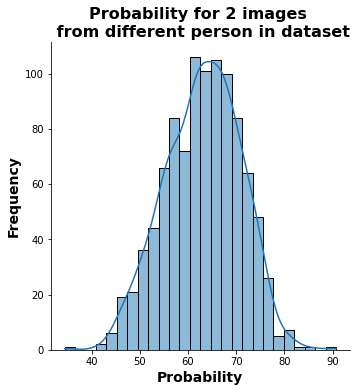

In [23]:
score_diff_base_model_df = pd.DataFrame(
                                  {'Probability': score_diff_base_model,
                                  'Images': img_cmp_diff_base_model,
                                  'Name': name_diff_base_model 
                                  })
plot_hist_one(score_diff_base_model_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [24]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_base_model, img_cmp_same_base_model, name_same_base_model = get_probability(num_test=num_test, model=base_model, 
                                                                                       img_list_same=samples_same, img_list_diff=None, 
                                                                                       similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 81.87% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 90.87% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 92.93% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 71.03% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 93.07% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 95.04% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 68.34% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 77.62% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 94.79% similar 

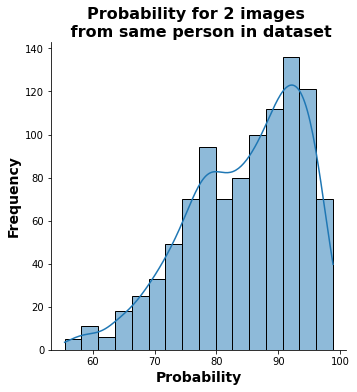

In [25]:
score_same_base_model_df = pd.DataFrame(
                                  {'Probability': score_same_base_model,
                                  'Images': img_cmp_same_base_model,
                                  'Name': name_same_base_model 
                                  })
plot_hist_one(score_same_base_model_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_base_model_df.to_csv(os.path.join(capstone_dir, 'dataset/same_base_model_results.csv'), index=False)
score_diff_base_model_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_base_model_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [32]:
score_same_base_model_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_base_model_results.csv'))
score_diff_base_model_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_base_model_results.csv'))

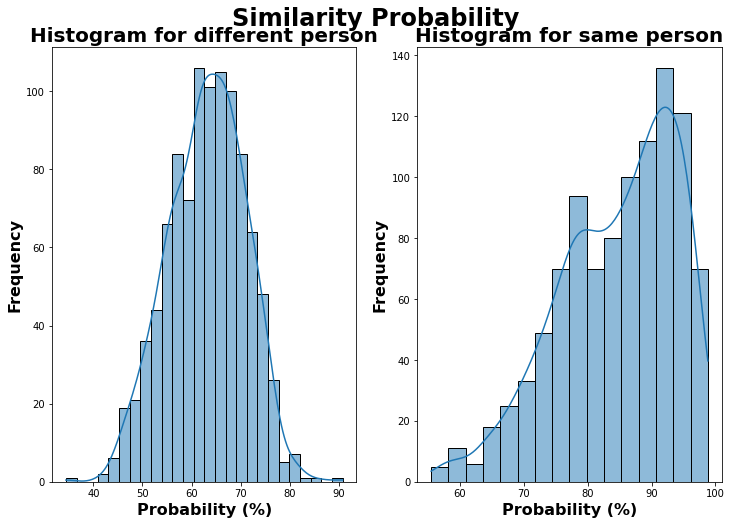

In [33]:
plot_hist([score_diff_base_model_df, score_same_base_model_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Base Model does not fare well for the similarity probability for 2 different person as majority of them falls from 50 to 75%.

## Model 1

In [33]:
# num_class = 100
# num_test = 1000
# path for the model weights
model1_path = "model_checkpoint/vgg/model1/weights.epoch15-0.9898-0.7499acc.hdf5"
# dropout layer value
model1_dropout_value = [0.1, 0.1]
# dropout layer name
two_layers_dropout_name = ['drop1', 'drop2']

In [34]:
# model_128_2layers = prepare_embedding_model_avg(layers_dims=layers_node_128, layers_name=layers_name, num_class=num_class, 
#                                                 model_weights=model_128_path, dropout_value=model_128_dropout_value, 
#                                                 dropout_name=dropout_name)
model1 = prepare_embedding_model(layers_dims=base_model_layers_dims, layers_name=two_layers_name, 
                                 num_class=num_class, model_weights=model1_path, dropout_value=model1_dropout_value, 
                                 dropout_name=two_layers_dropout_name)

In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

### Test for 2 Images of Different Person

In [35]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model1, img_cmp_diff_model1, name_diff_model1 = get_probability(num_test=num_test, model=model1, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 47.98% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 64.52% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 45.12% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 49.95% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 51.42% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 68.27% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 65.13% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg

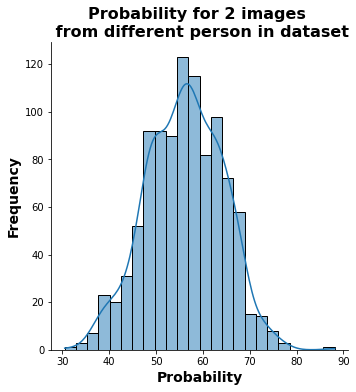

In [37]:
score_diff_model1_df = pd.DataFrame(
                                  {'Probability': score_diff_model1,
                                  'Images': img_cmp_diff_model1,
                                  'Name': name_diff_model1
                                  })
plot_hist_one(score_diff_model1_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model1, img_cmp_same_model1, name_same_model1 = get_probability(num_test=num_test, model=model1, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 75.57% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 87.74% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 92.33% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 68.21% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 89.6% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 94.47% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 62.13% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 76.13% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 91.32% similar t

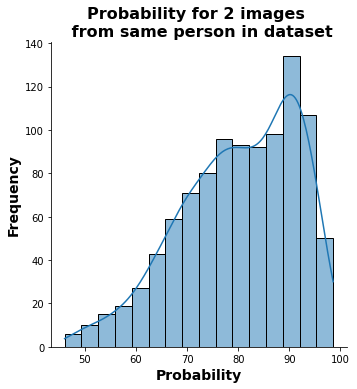

In [ ]:
score_same_model1_df = pd.DataFrame(
                                  {'Probability': score_same_model1,
                                  'Images': img_cmp_same_model1,
                                  'Name': name_same_model1
                                  })
plot_hist_one(score_same_model1_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model1_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model1_results.csv'), index=False)
score_diff_model1_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model1_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [34]:
score_same_128_2layers_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model1_results.csv'))
score_diff_128_2layers_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model1_results.csv'))

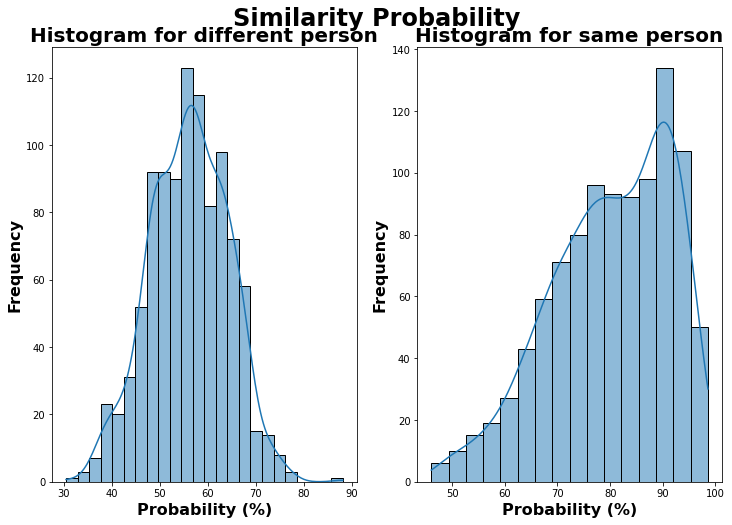

In [35]:
plot_hist([score_diff_128_2layers_df, score_same_128_2layers_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Model 1 perform better for the similarity probability for 2 different person as majority of them falls from 45 to 70%, which is lower than Base Model.

## Model 2

In [38]:
# layers_node_256 = [256, 256]
# model_256_path = "model_checkpoint/vgg/256x256x100_dropout_freeze1/weights.epoch07-0.9777-0.7868acc.hdf5"
# model_256_dropout_value = [0.3, 0.3]
# path for the model weights
model2_path = "model_checkpoint/vgg/model2/weights.epoch07-0.9777-0.7868acc.hdf5"
# dropout layer value
model2_dropout_value = [0.3, 0.3]
# number of nodes for each fully connected layer
model2_layers_dims = [256, 256]

In [39]:
model2 = prepare_embedding_model(layers_dims=model2_layers_dims, layers_name=two_layers_name, 
                                 num_class=num_class, model_weights=model2_path, dropout_value=model2_dropout_value, 
                                 dropout_name=two_layers_dropout_name)

In [40]:
# model_256_2layers = prepare_embedding_model_avg(layers_dims=layers_node_256, layers_name=layers_name, num_class=num_class, 
#                                                 model_weights=model_256_path, dropout_value=model_256_dropout_value, 
#                                                 dropout_name=dropout_name)
model2.summary()

Model: "model_18161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18154 (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       

### Test for 2 Images of Different Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model2, img_cmp_diff_model2, name_diff_model2 = get_probability(num_test=num_test, model=model2, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 51.06% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 51.52% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 44.41% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 41.88% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 47.26% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 62.88% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 60.15% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg

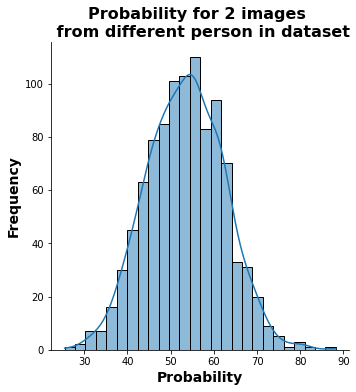

In [ ]:
score_diff_model2_df = pd.DataFrame(
                                  {'Probability': score_diff_model2,
                                  'Images': img_cmp_diff_model2,
                                  'Name': name_diff_model2
                                  })
plot_hist_one(score_diff_model2_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model2, img_cmp_same_model2, name_same_model2 = get_probability(num_test=num_test, model=model2, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 75.16% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 89.09% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 91.61% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 73.49% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 90.39% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 93.46% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 59.05% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 68.64% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 90.79% similar 

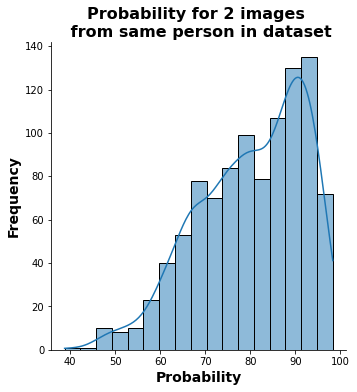

In [ ]:
score_same_model2_df = pd.DataFrame(
                                  {'Probability': score_same_model2,
                                  'Images': img_cmp_same_model2,
                                  'Name': name_same_model2
                                  })
plot_hist_one(score_same_model2_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model2_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model2_results.csv'), index=False)
score_diff_model2_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model2_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [36]:
score_same_model2_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model2_results.csv'))
score_diff_model2_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model2_results.csv'))

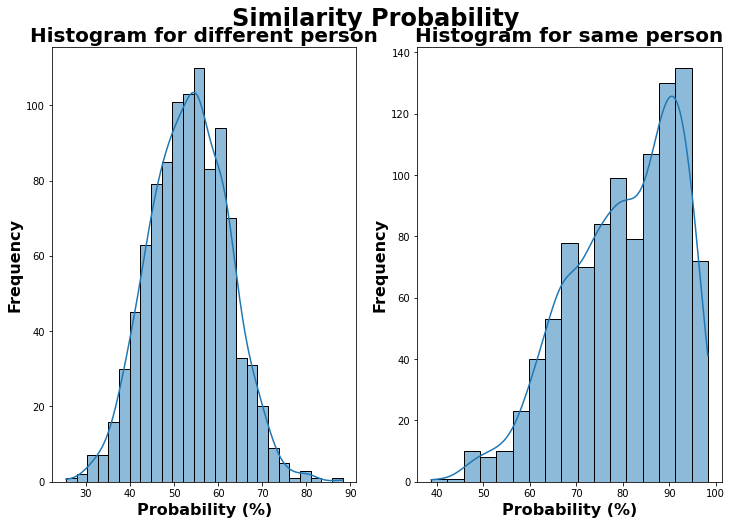

In [37]:
plot_hist([score_diff_model2_df, score_same_model2_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Model 2 perform the same for the similarity probability for 2 different person as Model 1. However, Model 1 still performs better for the similarity probability for the same person as with the same samples, Model 1 can predict images of the same person at least 50% which is higher than Model 2 at 40%. 

## Model 3

In [41]:
# # layers_name = ['fc6', 'fc7', 'fc8']
# layers_node_512 = [512, 512]
# # dropout_name = ['drop1', 'drop2']
# model_512_path = "model_checkpoint/vgg/512x512x100_dropout_freeze1/weights.epoch04-0.9676-0.7719acc.hdf5"
# model_512_dropout_value = [0.4, 0.4]
# # num_class = 100
# path for the model weights
model3_path = "model_checkpoint/vgg/model3/weights.epoch04-0.9676-0.7719acc.hdf5"
# dropout layer value
model3_dropout_value = [0.4, 0.4]
# number of nodes for each fully connected layer
model3_layers_dims = [512, 512]

In [42]:
model3 = prepare_embedding_model(layers_dims=model3_layers_dims, layers_name=two_layers_name, 
                                 num_class=num_class, model_weights=model3_path, dropout_value=model3_dropout_value, 
                                 dropout_name=two_layers_dropout_name)

In [ ]:
# model_512_2layers = prepare_embedding_model_avg(layers_dims=layers_node_512, layers_name=layers_name, num_class=num_class, 
#                                                 model_weights=model_512_path, dropout_value=model_512_dropout_value, 
#                                                 dropout_name=dropout_name)
model3.summary()

Model: "model_9403"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9388 (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0

### Test for 2 Images of Different Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model3, img_cmp_diff_model3, name_diff_model3 = get_probability(num_test=num_test, model=model3, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 48.43% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 59.16% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 43.73% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 46.17% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 42.3% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 59.26% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 58.13% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg 

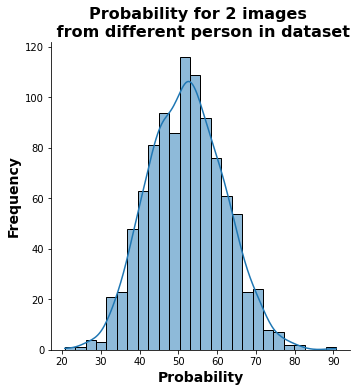

In [ ]:
score_diff_model3_df = pd.DataFrame(
                                  {'Probability': score_diff_model3,
                                  'Images': img_cmp_diff_model3,
                                  'Name': name_diff_model3
                                  })
plot_hist_one(score_diff_model3_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model3, img_cmp_same_model3, name_same_model3 = get_probability(num_test=num_test, model=model3, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

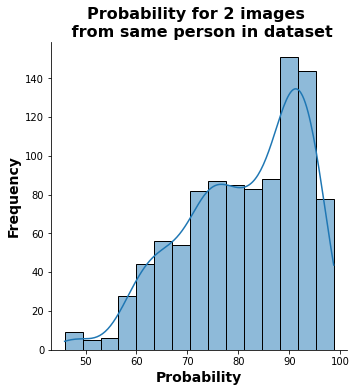

In [ ]:
score_same_model3_df = pd.DataFrame(
                                  {'Probability': score_same_model3,
                                  'Images': img_cmp_same_model3,
                                  'Name': name_same_model3
                                  })
plot_hist_one(score_same_model3_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model3_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model3_results.csv'), index=False)
score_diff_model3_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model3_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [38]:
score_same_model3_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model3_results.csv'))
score_diff_model3_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model3_results.csv'))

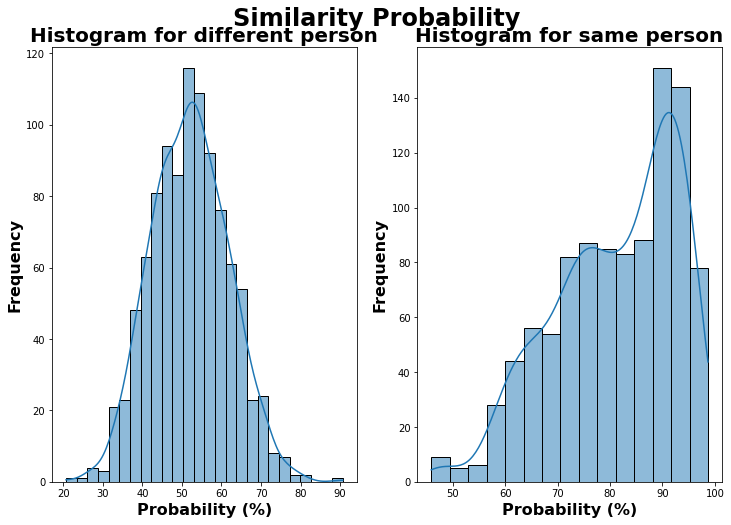

In [39]:
plot_hist([score_diff_model3_df, score_same_model3_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Model 3 perform better for the similarity probability for 2 different person as majority of them falls from 40 to 65% as well as achieving almost the same performance as Model 1 which is the best model up till now.

## Model 4

In [43]:
# # # number of classification class
# # num_class = 100
# # layers name for the classification block
# three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']
# # number of nodes for each fully connected layer
# three_layers_node_128 = [128, 128, 128]
# # path for the model weights
# three_layers_model_128_path = "model_checkpoint/vgg/128x128x128x100_dropout_freeze1/weights.epoch24-0.9880-0.7431acc.hdf5"
# three_layers_model_128_dropout_value = [0.1, 0.1, 0.1]
# three_layers_dropout_name = ['drop1', 'drop2', 'drop3']

# path for the model weights
model4_path = "model_checkpoint/vgg/model4/weights.epoch24-0.9880-0.7431acc.hdf5"
# dropout layer value
model4_dropout_value = [0.1, 0.1, 0.1]
# number of nodes for each fully connected layer
model4_layers_dims = [128, 128, 128]
# dropout layer name
three_layers_dropout_name = ['drop1', 'drop2', 'drop3']
# layers name for the classification block
# 3 hidden + 1 output
three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']

In [44]:
model4 = prepare_embedding_model(layers_dims=model4_layers_dims, layers_name=three_layers_name, 
                                 num_class=num_class, model_weights=model4_path, dropout_value=model4_dropout_value, 
                                 dropout_name=three_layers_dropout_name)

In [ ]:
# model_128_3layers = prepare_embedding_model_avg(layers_dims=three_layers_node_128, layers_name=three_layers_name, num_class=num_class, 
#                                                 model_weights=three_layers_model_128_path, dropout_value=three_layers_model_128_dropout_value,
#                                                 dropout_name=three_layers_dropout_name)
# # model_128 = prepare_embedding_model_avg([128, 128, 128], ['fc6', 'fc7', 'fc8', 'fc9'], ['drop1', 'drop2', 'drop3'], 100, "model_checkpoint/vgg/128x128x100_dropout/weights.epoch24-0.9880-0.7431acc.hdf5", 0.1)

In [45]:
model4.summary()

Model: "model_18167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18156 (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       

### Test for 2 Images of Different Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model4, img_cmp_diff_model4, name_diff_model4 = get_probability(num_test=num_test, model=model4, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 43.33% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 54.48% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 34.23% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 44.36% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 40.62% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 61.45% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 58.37% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg

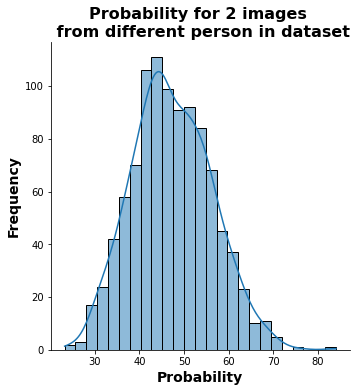

In [ ]:
score_diff_model4_df = pd.DataFrame(
                                  {'Probability': score_diff_model4,
                                  'Images': img_cmp_diff_model4,
                                  'Name': name_diff_model4
                                  })
plot_hist_one(score_diff_model4_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model4, img_cmp_same_model4, name_same_model4 = get_probability(num_test=num_test, model=model4, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 72.24% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 85.49% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 87.59% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 65.13% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 87.26% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 92.12% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 56.22% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 75.94% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 90.74% similar 

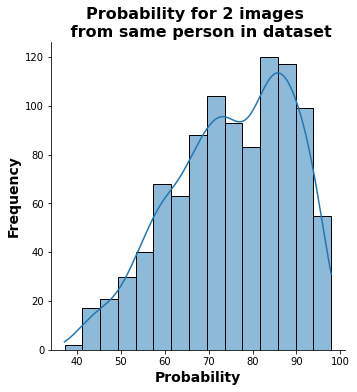

In [ ]:
score_same_model4_df = pd.DataFrame(
                                  {'Probability': score_same_model4_df,
                                  'Images': img_cmp_same_model4,
                                  'Name': name_same_model4
                                  })
plot_hist_one(score_same_model4_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model4_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model4_results.csv'), index=False)
score_diff_model4_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model4_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [40]:
score_same_model4_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model4_results.csv'))
score_diff_model4_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model4_results.csv'))

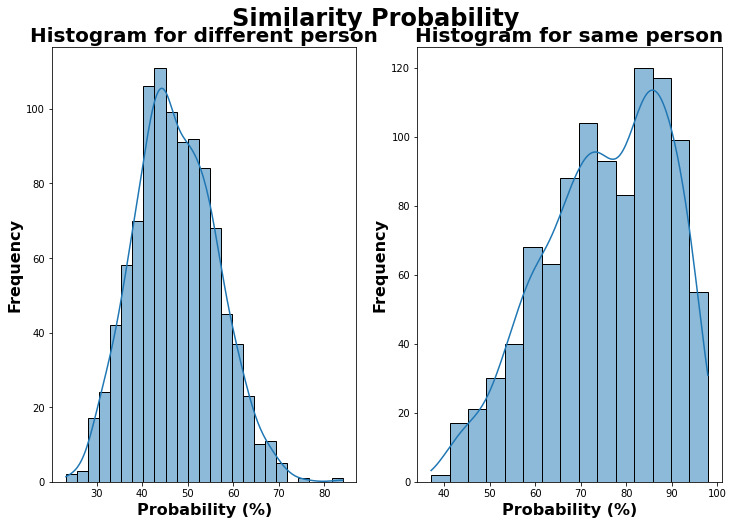

In [42]:
plot_hist([score_diff_model4_df, score_same_model4_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Model 4 perform better for the similarity probability for 2 different person as majority of them falls from 35 to 60% than Model 3. However, Model 3 still performs better for the images of the same person which can predict at least 50% similarity compared to Model 4's 40%.

## Model 5

In [46]:
# # # number of classification class
# # num_class = 100
# # layers name for the classification block
# # three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']
# # number of nodes for each fully connected layer
# three_layers_node_256 = [256, 256, 256]
# # path for the model weights
# three_layers_model_256_path = "model_checkpoint/vgg/256x256x256x100_dropout_freeze1/weights.epoch13-0.9735-0.7499acc.hdf5"
# three_layers_model_256_dropout_value = [0.3, 0.3, 0.3]
# # three_layers_dropout_name = ['drop1', 'drop2', 'drop3']

# path for the model weights
# model5_path = "model_checkpoint/vgg/model5/weights.epoch18-0.9781-0.7504acc.hdf5"
model5_path = "model_checkpoint/vgg/model5/weights.epoch13-0.9735-0.7499acc.hdf5"
# dropout layer value
model5_dropout_value = [0.3, 0.3, 0.3]
# number of nodes for each fully connected layer
model5_layers_dims = [256, 256, 256]

In [47]:
model5 = prepare_embedding_model(layers_dims=model5_layers_dims, layers_name=three_layers_name, 
                                 num_class=num_class, model_weights=model5_path, dropout_value=model5_dropout_value, 
                                 dropout_name=three_layers_dropout_name)

In [ ]:
# model_256_3layers = prepare_embedding_model_avg(layers_dims=three_layers_node_256, layers_name=three_layers_name, num_class=num_class, 
#                                                 model_weights=three_layers_model_256_path, dropout_value=three_layers_model_256_dropout_value,
#                                                 dropout_name=three_layers_dropout_name)
# # model_256 = prepare_embedding_model_avg([256, 256, 256], ['fc6', 'fc7', 'fc8', 'fc9'], ['drop1', 'drop2', 'drop3'], 100, "model_checkpoint/vgg/256x256x256x100_dropout_freeze1/weights.epoch13-0.9735-0.7499acc.hdf5", 0.3)

In [48]:
model5.summary()

Model: "model_18170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18157 (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       

### Test for 2 Images of Different Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model5, img_cmp_diff_model5, name_diff_model5 = get_probability(num_test=num_test, model=model5, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 48.58% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 49.74% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 28.99% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 40.45% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 34.43% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 61.79% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 51.27% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg

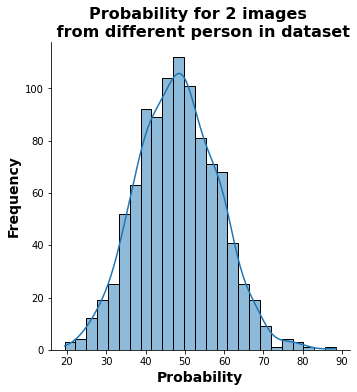

In [ ]:
score_diff_model5_df = pd.DataFrame(
                                  {'Probability': score_diff_model5,
                                  'Images': img_cmp_diff_model5,
                                  'Name': name_diff_model5
                                  })
plot_hist_one(score_diff_model5_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model5, img_cmp_same_model5, name_same_model5 = get_probability(num_test=num_test, model=model5, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 77.62% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 86.46% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 92.06% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 60.56% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 82.6% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 95.2% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 54.92% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 67.69% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 88.5% similar to 

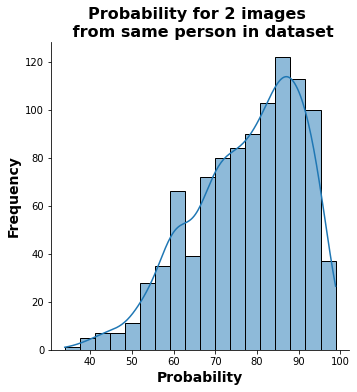

In [ ]:
score_same_model5_df = pd.DataFrame(
                                  {'Probability': score_same_model5,
                                  'Images': img_cmp_same_model5,
                                  'Name': name_same_model5
                                  })
plot_hist_one(score_same_model5_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model5_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model5_results.csv'), index=False)
score_diff_model5_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model5_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [43]:
score_same_model5_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model5_results.csv'))
score_diff_model5_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model5_results.csv'))

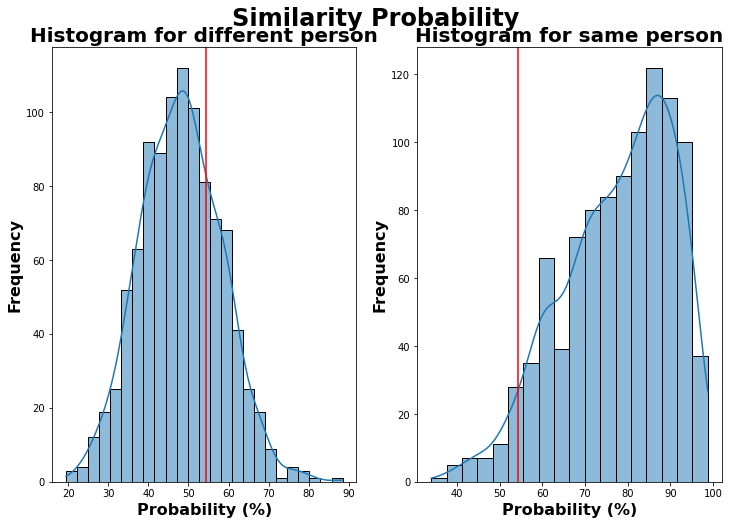

In [51]:
plot_hist([score_diff_model5_df, score_same_model5_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, Model 5 has almost the same performance as Model 4 for comparing images of same person and images of different persons.

## Model 6

In [49]:
# # # number of classification class
# # num_class = 100
# # layers name for the classification block
# # three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']
# # number of nodes for each fully connected layer
# three_layers_node_512 = [512, 512, 512]
# # path for the model weights
# three_layers_model_512_path = "model_checkpoint/vgg/512x512x512x100_dropout_freeze1/weights.epoch11-0.9672-0.7531acc.hdf5"
# three_layers_model_512_dropout_value = [0.4, 0.4, 0.4]
# # three_layers_dropout_name = ['drop1', 'drop2', 'drop3']

# path for the model weights
model6_path = "model_checkpoint/vgg/model6/weights.epoch11-0.9672-0.7531acc.hdf5"
# dropout layer value
model6_dropout_value = [0.4, 0.4, 0.4]
# number of nodes for each fully connected layer
model6_layers_dims = [512, 512, 512]

In [50]:
model6 = prepare_embedding_model(layers_dims=model6_layers_dims, layers_name=three_layers_name, 
                                 num_class=num_class, model_weights=model6_path, dropout_value=model6_dropout_value, 
                                 dropout_name=three_layers_dropout_name)

In [ ]:
# model_512_3layers = prepare_embedding_model_avg(layers_dims=three_layers_node_512, layers_name=three_layers_name, num_class=num_class, 
#                                                 model_weights=three_layers_model_512_path, dropout_value=three_layers_model_512_dropout_value,
#                                                 dropout_name=three_layers_dropout_name)

In [51]:
model6.summary()

Model: "model_18173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18158 (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       

### Test for 2 Images of Different Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_diff_model6, img_cmp_diff_model6, name_diff_model6 = get_probability(num_test=num_test, model=model6, 
                                                                           img_list_same=None, img_list_diff=samples_diff, 
                                                                           similar=False)

Face in Joao_Felix_0_1482.jpg for Joao Felix is 32.06% similar to face in Kylian_Mbappe_0_8925.jpg for Kylian Mbappe
1 comparison, 999 to go
Face in Jan_Oblak_0_5745.jpg for Jan Oblak is 40.77% similar to face in sterling12.jpg for Raheem Sterling
2 comparison, 998 to go
Face in Jurgen_Klopp_0_4366.jpg for Jurgen Klopp is 36.33% similar to face in firmino12.jpg for Roberto Firmino
3 comparison, 997 to go
Face in Jurgen_Klopp_0_4077.jpg for Jurgen Klopp is 36.99% similar to face in Toni_Kroos_0_8003.jpg for Toni Kroos
4 comparison, 996 to go
Face in ronaldinho12.jpg for Ronaldinho is 37.13% similar to face in courtois1.jpg for Thibaut Courtois
5 comparison, 995 to go
Face in David_Silva_0_3894.jpg for David Silva is 61.36% similar to face in Giorgio_Chiellini_0_2030.jpg for Giorgio Chiellini
6 comparison, 994 to go
Face in Javier_Mascherano_0_2141.jpg for Javier Mascherano is 58.74% similar to face in Jan_Oblak_0_7501.jpg for Jan Oblak
7 comparison, 993 to go
Face in Bernd_Leno_0_71.jpg

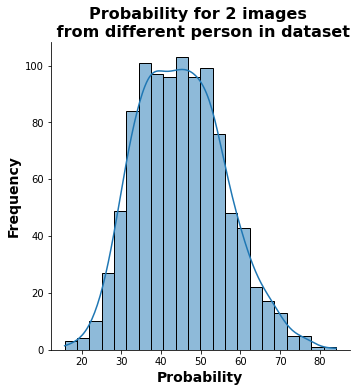

In [ ]:
score_diff_model6_df = pd.DataFrame(
                                  {'Probability': score_diff_model6,
                                  'Images': img_cmp_diff_model6,
                                  'Name': name_diff_model6
                                  })
plot_hist_one(score_diff_model6_df, 
          'Probability for 2 images \n from different person in dataset')

### Test for 2 Images of Same Person

In [ ]:
%%time
# about 7min for 100 test
# about 1hr 13min for 1000 test
score_same_model6, img_cmp_same_model6, name_same_model6 = get_probability(num_test=num_test, model=model6, 
                                                                           img_list_same=samples_same, img_list_diff=None, 
                                                                           similar=True)

Face in Georginio_Wijnaldum_0_8266.jpg is 67.67% similar to Georginio_Wijnaldum_0_6501.jpg for Georginio Wijnaldum
1 comparison, 999 to go
Face in figo12.jpg is 82.93% similar to Luis_Figo_0_2402.jpg for Luis Figo
2 comparison, 998 to go
Face in Antoine_Griezmann_0_8255.jpg is 90.4% similar to Antoine_Griezmann_0_8601.jpg for Antoine Griezmann
3 comparison, 997 to go
Face in Oliver_Giroud_0_4493.jpg is 72.46% similar to Oliver_Giroud_0_6753.jpg for Oliver Giroud
4 comparison, 996 to go
Face in Luis_Figo_0_3136.jpg is 86.23% similar to Luis_Figo_0_716.jpg for Luis Figo
5 comparison, 995 to go
Face in Robert_Lewandowski_0_152.jpg is 92.18% similar to Robert_Lewandowski_0_4458.jpg for Robert Lewandowski
6 comparison, 994 to go
Face in Luka_Modric_0_8062.jpg is 58.78% similar to modric12.jpg for Luka Modric
7 comparison, 993 to go
Face in Sadio_Mane_0_8500.jpg is 72.86% similar to Sadio_Mane_0_8440.jpg for Sadio Mane
8 comparison, 992 to go
Face in Leroy_Sane_0_5350.jpg is 87.58% similar t

In [ ]:
score_same_model6_df = pd.DataFrame(
                                  {'Probability': score_same_model6,
                                  'Images': img_cmp_same_model6,
                                  'Name': name_same_model6
                                  })
plot_hist_one(score_same_model6_df, 
          'Probability for 2 images \n from same person in dataset')

### Save to csv file

As the test took about 1 hour for 1000 samples, hence the results are saved into a csv file so that we can load the data without having to run the test again.

In [ ]:
score_same_model6_df.to_csv(os.path.join(capstone_dir, 'dataset/same_model6_results.csv'), index=False)
score_diff_model6_df.to_csv(os.path.join(capstone_dir, 'dataset/diff_model6_results.csv'), index=False)

### Load the samples that were saved after computing the score, probability and images used

Load the data that had been saved previously so that we can to plot the graph again without having to run the test again.

In [46]:
score_same_model6_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/same_model6_results.csv'))
score_diff_model6_df = pd.read_csv(os.path.join(capstone_dir, 'dataset/diff_model6_results.csv'))

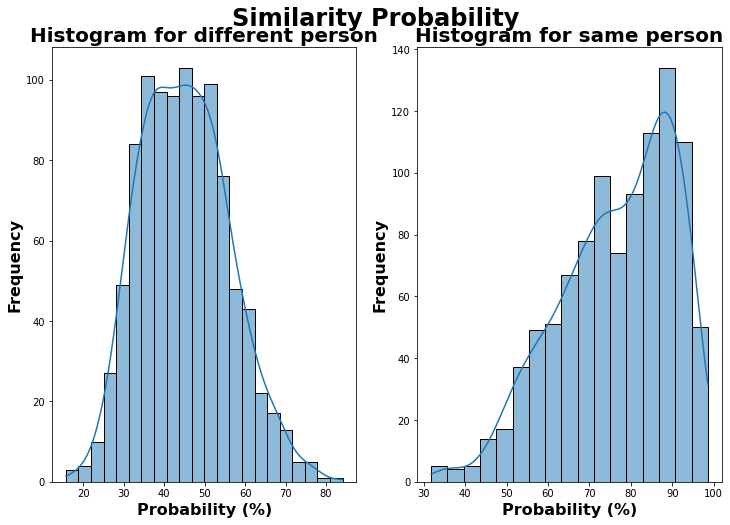

In [47]:
plot_hist([score_diff_model6_df, score_same_model6_df], ['different person', 'same person'], 'Similarity Probability', 2, (12, 8))

# # save the figure
# plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

From the plots above, the Model 6 perform better for the similarity probability for 2 different person as majority of them falls from 30 to 60% as compared to Model 4 and Model 5 which ranges from 35 to 60%. However, Model 6 performs worse for the images of the same person which can predict at least 30% similarity compared to Model 4 and Model 5's 40%.

## Chosen Model

The table below shows the performance of each of the models in the taken from the previous notebook:


Model  | Hidden Layer Nodes | Dropout Layers Values | Training Accuracy | Validation Accuracy | Test Accuracy | Remarks
-------------------|------------------|-------------------|------------------|------------------|--------------------|------------------|
Base Model | [128, 128] | - | 99% | 73.2% | 78.5% | Trained the last trainable layer of VGGFace
Base Model 2 | [128, 128] | - | 99% | 64.5% | 75.5% | Trained the last 2 trainable layers of VGGFace
Model 1 | [128, 128] | [0.1, 0.1] | 99% | 75% | 76.3% | Trained the last trainable layer of VGGFace
Model 2 | [256, 256] | [0.3, 0.3] | 97.8% | 78.7% | 81.5% | Trained the last trainable layer of VGGFace
Model 3 | [512, 512] | [0.4, 0.4] | 96.8% | 77.2% | 80.2% | Trained the last trainable layer of VGGFace
Model 4 | [128, 128, 128] | [0.1, 0.1, 0.1] | 98.8% | 74.3% | 78.2% | Trained the last trainable layer of VGGFace
Model 5| [256, 256, 256] | [0.3, 0.3, 0.3] | 97.4% | 75% | 78.4% | Trained the last trainable layer of VGGFace
Model 6 | [512, 512, 512] | [0.4, 0.4, 0.4] | 96.7% | 75.3% | 77.1% | Trained the last trainable layer of VGGFace

Although Model 6 performs better that Model 4 and 5 which are the 2 models that are the better ones up till now, the performace of Model 6 for the images of same person was quite bad as it can reach to as low as 30% which is not what we expect for imsges of the same person. Eventually, Model 5 was the chosen model as it performs quite well across the training, validation and test compared to Model 4. Model 5 will be used in the next notebook to test out on images and video to see how well it performs.

In [62]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Set Threshold 

As this project is to identify people of interest, the true positive would be correctly identify 2 images of the same person where the true negative would be to correctly identify 2 images of differenet person. Hence in order to only allow false negative of 5% from 1000 samples, we can only allow 50 to be detected as false negative. This will help us to set the threshold. 

By sorting the probability of the dataframe that we saved earlier, and try to locate the 50th samples from bottom will give us the threshhold. In this case, our threshold will be 54.37%.

In [65]:
score_same_model5_df.sort_values(by='Probability', ascending=False).tail(50)

,Probability,Images,Name
635,54.37,"['Bernd_Leno_0_71.jpg', 'Bernd_Leno_0_2581.jpg']",Bernd Leno
824,54.29,"['kroos1.jpg', 'Toni_Kroos_0_8542.jpg']",Toni Kroos
332,54.28,"['Ederson_Moraes_0_2482.jpg', 'Ederson_Moraes_...",Ederson Moraes
935,53.94,"['Falcao_0_1354.jpg', 'Falcao_0_825.jpg']",Falcao
276,53.94,"['Falcao_0_1354.jpg', 'Falcao_0_825.jpg']",Falcao
931,53.88,"['Pierre_Emerick_Aubameyang_0_7327.jpg', 'Pier...",Pierre Emerick Aubameyang
673,53.81,"['Toni_Kroos_0_9789.jpg', 'Toni_Kroos_0_1916.j...",Toni Kroos
869,53.35,"['klopp12.jpeg', 'Jurgen_Klopp_0_720.jpg']",Jurgen Klopp
850,53.18,"['Robbie_Fowler_0_3721.jpg', 'Robbie_Fowler_0_...",Robbie Fowler
426,52.59,"['Robbie_Fowler_0_3576.jpg', 'Robbie_Fowler_0_...",Robbie Fowler


In [70]:
score_diff_model5_df.loc[score_diff_model5_df['Probability'] > 54.37, :].count()

Probability    269
Images         269
Name           269
dtype: int64

Recall - 95%, Specificity - 73.1%

In [71]:
score_same_model5_df.sort_values(by='Probability', ascending=False).tail(100)

,Probability,Images,Name
284,59.40,"['Pierre_Emerick_Aubameyang_0_976.jpg', 'Pierr...",Pierre Emerick Aubameyang
42,59.39,"['Roberto_Firmino_0_4904.jpg', 'Roberto_Firmin...",Roberto Firmino
297,59.38,"['Thiago_Silva_0_6070.jpg', 'Thiago_Silva_0_22...",Thiago Silva
970,59.24,"['Xabi_Alonso_0_8268.jpg', 'Xabi_Alonso_0_3791...",Xabi Alonso
135,59.22,"['Ryan_Giggs_0_7738.jpg', 'Ryan_Giggs_0_4826.j...",Ryan Giggs
915,59.20,"['Javier_Mascherano_0_5185.jpg', 'Javier_Masch...",Javier Mascherano
88,59.12,"['Christian_Eriksen_0_4998.jpg', 'Christian_Er...",Christian Eriksen
458,58.95,"['Pierre_Emerick_Aubameyang_0_7202.jpg', 'Pier...",Pierre Emerick Aubameyang
722,58.73,"['Leroy_Sane_0_6161.jpg', 'sane1.jpg']",Leroy Sane
645,58.73,"['Steven_Gerrard_0_4711.jpg', 'Steven_Gerrard_...",Steven Gerrard


In [72]:
score_diff_model5_df.loc[score_diff_model5_df['Probability'] > 59.4, :].count()

Probability    138
Images         138
Name           138
dtype: int64

Recall - 90%, Specificity - 86.2%

The above code check for the threshold to set for our chosen model to differentiate 2 images if theya re similar or different. In this project, the 54.4% threshold is chosen for the model as we want to accurately identify the person of interest and also consider that the specificity can still achieve 73%, which is quite good.